#**DigitalPolice Train Model**

---



This notebook contains the steps to build the Machine Learning model to detect anomaly from the surveillance camera videos. 

The steps are:

1. Splitting the extracted Anomaly dataset into training and testing, since from the dataset of [UCF101-Crime](https://www.crcv.ucf.edu/research/real-world-anomaly-detection-in-surveillance-videos/) that we got is already provided the splitted Normal dataset in training and testing.
2. Create directory for the training and testing dataset
3. Load the dataset into colab for training the model
4. Building the model : build custom generator, loss, and callbacks function, and the model referenced from the [paper](https://openaccess.thecvf.com/content_cvpr_2018/papers/Sultani_Real-World_Anomaly_Detection_CVPR_2018_paper.pdf).
5. Analyzing the training results and visualization


##**Connect Colab to the GCP Bucket to obtain the extracted dataset**

For the training model, we use the dataset that already preprocessed to extracting the features from the video open dataset using the C3D pre-trained model. The extracted dataset is stored at our GCP Bucket called ucf-fcrime in `/out/` directory, then we obtain the dataset to colab for training. In colab we can see it in `folderOnColab/out/` directory

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  68567      0 --:--:-- --:--:-- --:--:-- 66763
OK
97 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 97 not upgraded.
Need to get 10.8 MB of archives.
After this operation, 23.1 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.35.0_amd64.deb ...
Unpacking gcsfuse (0.35.0) ...
Setting up gcsfuse (0.35.0) ...


In [3]:
!mkdir folderOnColab
!gcsfuse --implicit-dirs ucf-fcrime /content/folderOnColab

2021/06/02 11:59:37.268070 Using mount point: /content/folderOnColab
2021/06/02 11:59:37.276330 Opening GCS connection...
2021/06/02 11:59:37.883200 Mounting file system "ucf-fcrime"...
2021/06/02 11:59:37.922466 File system has been successfully mounted.


##**Create directory for the training and testing dataset**

Before we split the anomaly dataset into training and testing, we should create and specify the directory to contain the files or data.

In [1]:
# Define directories
import os

base_dir = '/content/folderOnColab/out'


train_anomaly_dir = os.path.join(base_dir, 'Train-Anomaly') # Directory with our training anomaly extracted features
train_normal_dir = os.path.join(base_dir, 'Train-Normal') # Directory with our training normal extracted features
validation_anomaly_dir = os.path.join(base_dir, 'Test-Anomaly') # Directory with our validation anomaly extracted features
validation_normal_dir = os.path.join(base_dir, 'Test_Normal')# Directory with our validation normal extracted features


##**Splitting the dataset**

The Normal dataset is already divided into Training and Testing before, yet it is not done for the Anomaly dataset. Therefore, we splitted the Anomaly dataset to training and testing into **80 : 20** ratio by selecting random files from total anomaly data in `Anomaly_data` directory, and separate the 80% to training data and the rest to testing data. The anomaly data contains specific crime category dataset i.e Robbery, Vandalism, Stealing, and Assault as we want to detect these type of anomaly. 

First, we define the function to split the dataset into training and testing with 80% for the training data.

In [6]:
#split dataset

import random

train_data_percentage = 0.8    # split the Anomaly dataset into 80:20, 80% = 0.8 for training
anomaly_files = os.listdir('/content/folderOnColab/out/Anomaly_data') # specify Anomaly data source directory in GCP Bucket
print(len(anomaly_files)) #output the total anomaly data

def split_train_test( filenames, percentage):
  
  total_files = len(filenames) #count all files from the dataset
  total_train = int(total_files * train_data_percentage) #count files from the dataset for training
  
  train_set = []                             #create list for the training data
  
  while (len(train_set) != total_train):     #keep add files for training until reach 80% of data
    files = random.randrange(total_files)    #select random files to train
    if files not in train_set:
      train_set.append(files)                #add files to the training set

  test_set = []                              #create list for the testing data
  for i in range(total_files):               #iterate to find files for training from all dataset
    if i in train_set:
      print("skipping " + str(i))            #skip file that already included in training set to put in testing set
      continue
    else:
      test_set.append(i)                     #add files to the training set
    
  train_files =[]
  for i in train_set:    
    train_files.append(filenames[i])
   
  test_files =[]
  for i in test_set:    
    test_files.append(filenames[i])
  
  return (train_files, test_files)

338


Then we do the splitting for the anomaly data while skipping the existing files in the training data to separate the testing data, without containing the same data within the training data

In [8]:
anomaly_train_test = (split_train_test (anomaly_files , train_data_percentage)) # splitting the dataset


skipping 0
skipping 2
skipping 5
skipping 6
skipping 7
skipping 8
skipping 9
skipping 10
skipping 11
skipping 12
skipping 13
skipping 14
skipping 15
skipping 16
skipping 17
skipping 18
skipping 19
skipping 22
skipping 24
skipping 25
skipping 26
skipping 27
skipping 28
skipping 29
skipping 31
skipping 33
skipping 35
skipping 36
skipping 37
skipping 38
skipping 39
skipping 40
skipping 41
skipping 42
skipping 43
skipping 44
skipping 45
skipping 47
skipping 48
skipping 49
skipping 50
skipping 51
skipping 52
skipping 53
skipping 55
skipping 56
skipping 58
skipping 59
skipping 61
skipping 62
skipping 63
skipping 65
skipping 66
skipping 67
skipping 68
skipping 69
skipping 70
skipping 71
skipping 72
skipping 73
skipping 76
skipping 77
skipping 78
skipping 79
skipping 80
skipping 81
skipping 82
skipping 83
skipping 84
skipping 85
skipping 86
skipping 87
skipping 88
skipping 89
skipping 90
skipping 92
skipping 95
skipping 97
skipping 100
skipping 101
skipping 102
skipping 103
skipping 104
skippi

after separating the dataset we copy the splitted dataset into specific directories for each training and testing anomaly data.

In [12]:
# Copy Anomaly files from source directory to train directory
from shutil import copyfile    

base_dir = "/content/folderOnColab/out/" #specify directory path

# Copy Anomaly train files from source directory to train directory
length = len (anomaly_train_test[0])
for i in range(length):
  source = ("/content/folderOnColab/out/Anomaly_data/" + anomaly_train_test[0][i])
  destination = (train_anomaly_dir + "/" + anomaly_train_test[0][i])
  print ("Copying anomaly train files from {} to {}".format(source, destination))
  copyfile(source, destination)

train_anomaly = os.listdir(train_anomaly_dir) 
print(f"Number of train files with anomaly copied: {len(train_anomaly)}")  
  
# Copy Anomaly test files from source directory to train directory
length = len (anomaly_train_test[1])
for i in range(length):
  source = ("/content/folderOnColab/out/Anomaly_data/" + anomaly_train_test[1][i])
  destination = (validation_anomaly_dir + "/" + anomaly_train_test[1][i])
  print ("Copying anomaly test files from {} to {}".format(source, destination))
  copyfile(source, destination)

valid_anomaly = os.listdir(validation_anomaly_dir) 
print(f"Number of test files with anomaly copied: {len(valid_anomaly)}")


Copying anomaly train files from /content/folderOnColab/out/Anomaly_data/Stealing043_x264.txt to /content/folderOnColab/out/Train-Anomaly2/Stealing043_x264.txt
Copying anomaly train files from /content/folderOnColab/out/Anomaly_data/Assault016_x264.txt to /content/folderOnColab/out/Train-Anomaly2/Assault016_x264.txt
Copying anomaly train files from /content/folderOnColab/out/Anomaly_data/Robbery012_x264.txt to /content/folderOnColab/out/Train-Anomaly2/Robbery012_x264.txt
Copying anomaly train files from /content/folderOnColab/out/Anomaly_data/Assault009_x264.txt to /content/folderOnColab/out/Train-Anomaly2/Assault009_x264.txt
Copying anomaly train files from /content/folderOnColab/out/Anomaly_data/Stealing073_x264.txt to /content/folderOnColab/out/Train-Anomaly2/Stealing073_x264.txt
Copying anomaly train files from /content/folderOnColab/out/Anomaly_data/Stealing008_x264.txt to /content/folderOnColab/out/Train-Anomaly2/Stealing008_x264.txt
Copying anomaly train files from /content/fold

##**Load the dataset**

Then, we should load the dataset that we want to used into colab to do the training step. First we need to import the necessary modules, then create the function to load the dataset, and last do the loading. To avoid huge use of memory in colab we should clear the session.

In [2]:
#import necessary modules
import numpy as np
import random
import tensorflow as tf

In [3]:
# create function to load the dataset from GCP Bucket to Colab

def load_all_dataset(abnormal_path, normal_path):

  normal_video_take = len(os.listdir(normal_path))
  abnormal_video_take = len(os.listdir(abnormal_path))

  normal_folder = os.listdir(normal_path)
  abnormal_folder = os.listdir(abnormal_path)

  len_normal_folder = len(normal_folder)
  len_abnormal_folder = len(abnormal_folder)


  normal_list = normal_folder # np.random.choice(normal_folder, size=normal_video_take, replace=False)
  abnormal_list = abnormal_folder # np.random.choice(abnormal_folder, size=abnormal_video_take, replace=False)

  all_normal = []
  all_abnormal = []

  for normal_file in normal_list:
    try:
      with open(os.path.join(normal_path, normal_file), 'r') as normal_f:
        print("reading " + normal_file)
        normal_words = normal_f.read().split()
        normal_num_feat = len(normal_words) / 4096
        btch_normal = []
        for normal_feat in range(0, int(normal_num_feat)):
          normal_feat_row = np.float32(normal_words[normal_feat * 4096:normal_feat * 4096 + 4096])
          btch_normal.append(normal_feat_row)
        all_normal.append(np.array(btch_normal))

    except IsADirectoryError:
      print("continue because " + normal_file + " is a directory")
      pass

  for abnormal_file in abnormal_list:
    try:
      with open(os.path.join(abnormal_path, abnormal_file), 'r') as abnormal_f:
        print("reading " + abnormal_file)
        abnormal_words = abnormal_f.read().split()
        abnormal_num_feat = len(abnormal_words) / 4096
        btch_abnormal = []
        for abnormal_feat in range(0, int(abnormal_num_feat)):
          abnormal_feat_row = np.float32(abnormal_words[abnormal_feat * 4096:abnormal_feat * 4096 + 4096])
          btch_abnormal.append(abnormal_feat_row)

        all_abnormal.append(np.array(btch_abnormal))

    except IsADirectoryError:
      print("continue because " + abnormal_file + " is a directory")
      pass

  return np.array(all_normal), np.array(all_abnormal)
      


In [4]:
#load the dataset for training

train_normal_x, train_abnormal_x = load_all_dataset(train_anomaly_dir, train_normal_dir)

reading Normal_Videos001_x264.txt
reading Normal_Videos002_x264.txt
reading Normal_Videos004_x264.txt
reading Normal_Videos007_x264.txt
reading Normal_Videos008_x264.txt
reading Normal_Videos009_x264.txt
reading Normal_Videos011_x264.txt
reading Normal_Videos012_x264.txt
reading Normal_Videos013_x264.txt
reading Normal_Videos016_x264.txt
reading Normal_Videos017_x264.txt
reading Normal_Videos021_x264.txt
reading Normal_Videos023_x264.txt
reading Normal_Videos026_x264.txt
reading Normal_Videos028_x264.txt
reading Normal_Videos029_x264.txt
reading Normal_Videos030_x264.txt
reading Normal_Videos031_x264.txt
reading Normal_Videos032_x264.txt
reading Normal_Videos035_x264.txt
reading Normal_Videos036_x264.txt
reading Normal_Videos038_x264.txt
reading Normal_Videos039_x264.txt
reading Normal_Videos040_x264.txt
reading Normal_Videos043_x264.txt
reading Normal_Videos044_x264.txt
reading Normal_Videos045_x264.txt
reading Normal_Videos046_x264.txt
reading Normal_Videos047_x264.txt
reading Normal

In [5]:
#load the dataset for testing
test_normal_x, test_abnormal_x = load_all_dataset(validation_anomaly_dir, validation_normal_dir)

reading Normal_Videos_003_x264.txt
reading Normal_Videos_010_x264.txt
reading Normal_Videos_014_x264.txt
reading Normal_Videos_018_x264.txt
reading Normal_Videos_019_x264.txt
reading Normal_Videos_024_x264.txt
reading Normal_Videos_025_x264.txt
reading Normal_Videos_027_x264.txt
reading Normal_Videos_033_x264.txt
reading Normal_Videos_034_x264.txt
reading Normal_Videos_041_x264.txt
reading Normal_Videos_042_x264.txt
reading Normal_Videos_048_x264.txt
reading Normal_Videos_050_x264.txt
reading Normal_Videos_051_x264.txt
reading Normal_Videos_056_x264.txt
reading Normal_Videos_059_x264.txt
reading Normal_Videos_067_x264.txt
reading Normal_Videos_070_x264.txt
reading Normal_Videos_100_x264.txt
reading Normal_Videos_150_x264.txt
reading Normal_Videos_168_x264.txt
reading Normal_Videos_175_x264.txt
reading Normal_Videos_182_x264.txt
reading Normal_Videos_189_x264.txt
reading Normal_Videos_196_x264.txt
reading Normal_Videos_203_x264.txt
reading Normal_Videos_210_x264.txt
reading Normal_Video

In [6]:
tf.keras.backend.clear_session()

##**Building the model**

After the dataset is ready, then we build the model. In this model we use custom generator, loss function, and Roc callback referencing to the resource paper.

First, we create the custom generator and specify each for training and testing

In [7]:
#create custom generator

def generator(normal_x, abnormal_x, batchsize):
  n_exp= int(batchsize/2)
  
  
  while True:
    normal_x_indices = np.arange(normal_x.shape[0])
    abnormal_x_indices = np.arange(abnormal_x.shape[0])

    normal_get = np.random.choice(normal_x_indices, n_exp, replace=False)
    abnormal_get = np.random.choice(abnormal_x_indices, n_exp, replace=False)


    Abnor_list_iter = abnormal_x[abnormal_get]
    Norm_list_iter = normal_x[normal_get]
    

    AllFeatures = []
    # print("Loading Anomaly videos Features...")

    Video_count=-1
    for normal_video in Norm_list_iter:
      Video_count=Video_count+1
      count = -1;
      VideoFeatures = []
      for feat in normal_video:
        count = count + 1
        if count == 0:
          VideoFeatures = feat
        if count > 0:
          VideoFeatures = np.vstack((VideoFeatures, feat))

      if Video_count == 0:
        AllFeatures = VideoFeatures
      if Video_count > 0:
        AllFeatures = np.vstack((AllFeatures, VideoFeatures))

    # print(" Abnormal Features  loaded")
    
    # print("Loading Normal videos...")
    # print(AllFeatures.shape)
    for abnormal_video in Abnor_list_iter:
      Video_count=Video_count+1
      # print("[{}] loading vide {}".format(Video_count, VideoPath))
      
      count = -1;
      VideoFeatures = []
      for feat in abnormal_video:
        count = count + 1
        if count == 0:
          VideoFeatures = feat
        if count > 0:
          VideoFeatures = np.vstack((VideoFeatures, feat))

      AllFeatures = np.vstack((AllFeatures, VideoFeatures))

    # print("Features  loaded")

    AllLabels = np.zeros(32*batchsize, dtype='float32')
    th_loop1=n_exp*32
    th_loop2=n_exp*32-1

    for iv in range(0, 32*batchsize):
      if iv< th_loop1:
        AllLabels[iv] = 0.0
      if iv > th_loop2:
        AllLabels[iv] = 1.0

    # print(np.array(AllFeatures).shape)
    # print(np.array(AllLabels).shape)

    yield  np.array(AllFeatures), np.array(AllLabels)


In [8]:
#specify the generator for training and testing with batch size = 60 

train_generator = generator(train_normal_x, train_abnormal_x, 60)
validation_generator = generator(test_normal_x, test_abnormal_x, 60)

Then, create the ROC calback function 

In [9]:
#create ROC callback function

from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

class RocCallback(Callback):
  def __init__(self,gen):
    self.gen = gen


  def on_train_begin(self, logs={}):
    return

  def on_train_end(self, logs={}):
    return

  def on_epoch_begin(self, epoch, logs={}):
    return

  def on_epoch_end(self, epoch, logs={}):
    x,y = next(self.gen)
    y_pred = self.model.predict(x)
    roc = roc_auc_score(y, y_pred)
    print("the roc = {}".format(roc))
    return

  def on_batch_begin(self, batch, logs={}):
    return

  def on_batch_end(self, batch, logs={}):
    return

roc = RocCallback(generator(train_normal_x, train_abnormal_x, 60))

after that, create the custom loss function

In [10]:
#create custom loss function

@tf.function
def custom_objective(y_true, y_pred):
    
  y_true = tf.reshape(y_true, [-1])
  y_pred = tf.reshape(y_pred, [-1])

  # print(y_true)
  # print(y_pred)
  
  n_seg = 32
  nvid = 60
  n_exp = nvid / 2
  n_exp = int(n_exp)
  Num_d=32*nvid

  sub_max = tf.ones_like(y_pred)
  sub_sum_labels = tf.ones_like(y_true)
  sub_sum_l1= tf.ones_like(y_true) 
  sub_l2 = tf.ones_like(y_true)

  for ii in range(0, nvid, 1):
    
    mm = y_true[ii * n_seg:ii * n_seg + n_seg]
    # print(tf.stack([tf.math.reduce_sum(mm)]))
    sub_sum_labels = tf.concat([sub_sum_labels, tf.stack([tf.math.reduce_sum(mm)])], 0)

    Feat_Score = y_pred[ii * n_seg:ii * n_seg + n_seg]
    sub_max = tf.concat([sub_max, tf.stack([tf.math.reduce_max(Feat_Score)])], 0)  
    sub_sum_l1 = tf.concat([sub_sum_l1, tf.stack([tf.math.reduce_sum(Feat_Score)])], 0)

    z1 = tf.ones_like(Feat_Score)
    z2 = tf.concat([z1, Feat_Score], 0)
    z3 = tf.concat([Feat_Score, z1], 0)
    z_22 = z2[31:]
    z_44 = z3[:33]
    z = z_22 - z_44
    z = z[1:32]
    z = tf.math.reduce_sum(tf.math.square(z))
    sub_l2 = tf.concat([sub_l2, tf.stack([z])], 0)


  sub_score = sub_max[Num_d:]
  F_labels = sub_sum_labels[Num_d:]
  

  sub_sum_l1 = sub_sum_l1[Num_d:]
  sub_sum_l1 = sub_sum_l1[:n_exp]
  sub_l2 = sub_l2[Num_d:]
  sub_l2 = sub_l2[:n_exp]

  indx_nor = tf.where(tf.math.equal(F_labels, 0))# tf.experimental.numpy.nonzero(tf.cond(tf.math.equal(F_labels, 32), lambda: 1, lambda: 0))[0]
  indx_abn = tf.where(tf.math.equal(F_labels, 32))# tf.experimental.numpy.nonzero(tf.cond(tf.math.equal(F_labels, 0), lambda: 1, lambda: 0))[0]

  n_Nor=n_exp

  Sub_Nor = tf.gather_nd(sub_score, indx_nor)
  Sub_Abn = tf.gather_nd(sub_score, indx_abn)

  z = tf.ones_like(y_true)
  for ii in range(0, n_Nor, 1):
    # print(Sub_Abn)
    # print(Sub_Nor)
    sub_z = tf.math.maximum(1 - Sub_Abn[ii] + Sub_Nor[ii], 0)
    z = tf.concat([z, tf.stack([tf.math.reduce_sum(sub_z)])], 0)

  z = z[Num_d:]
  z = tf.math.reduce_mean(z, axis=-1) +  0.00008*tf.math.reduce_sum(sub_sum_l1) + 0.00008*tf.math.reduce_sum(sub_l2)
  # print(z)
  return z

Lasts, build the CNN model that referenced to the resources paper

In [11]:
#building the CNN model with input shape 4096 as a result from the extracted features using C3D
#use 0.6 dropout between the layers
#output one to determine anomaly (1) or normal (0)

model = tf.keras.Sequential([
                             tf.keras.layers.Input(shape=(4096,)),
                             tf.keras.layers.Dropout(0.6),
                             tf.keras.layers.Dense(512, kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.L2(0.001), activation='relu'),
                             tf.keras.layers.Dropout(0.6),
                             tf.keras.layers.Dense(32, kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.L2(0.001)),
                             tf.keras.layers.Dropout(0.6),
                             tf.keras.layers.Dense(1, kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.L2(0.001), activation='sigmoid'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2097664   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                16416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,114,113
Trainable params: 2,114,113
Non-trainable params: 0
______________________________________________

To compile the model we use Adagrad optimizer with learning rate 0.1 and use the custom loss function

In [12]:
#compile the model with Adagrad optimizer and custom loss function
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.01, epsilon=1e-08), loss=custom_objective)

Train the model in 500 epochs to avoid overfitting. For analyses purposes we specify the model into history variable to plot it in graph visualization

In [13]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=500, steps_per_epoch=1, validation_steps=1, callbacks=[roc])

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/concat_1:0", shape=(None,), dtype=int64), values=Tensor("gradients/concat:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherNd_grad/Shape:0", shape=(1,), dtype=int64))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


1/1 [==============================] - 20s 20s/step - loss: 2.0105 - val_loss: 2.0102
the roc = 0.38908474392361114
Epoch 2/500
1/1 [==============================] - 2s 2s/step - loss: 2.0146 - val_loss: 2.0109
the roc = 0.46478678385416666
Epoch 3/500
1/1 [==============================] - 2s 2s/step - loss: 2.0074 - val_loss: 2.0122
the roc = 0.5664485677083333
Epoch 4/500
1/1 [==============================] - 2s 2s/step - loss: 2.0097 - val_loss: 2.0107
the roc = 0.4616970486111111
Epoch 5/500
1/1 [==============================] - 2s 2s/step - loss: 2.0116 - val_loss: 2.0103
the roc = 0.4920241970486111
Epoch 6/500
1/1 [==============================] - 2s 2s/step - loss: 2.0187 - val_loss: 2.0091
the roc = 0.4547048611111111
Epoch 7/500
1/1 [==============================] - 2s 2s/step - loss: 2.0166 - val_loss: 2.0093
the roc = 0.4021538628472222
Epoch 8/500
1/1 [==============================] - 2s 2s/step - loss: 2.0164 - val_loss: 2.0096
the roc = 0.5408512369791667
Epoch 9/

###**save the model**

After the model is done training, we save the model for deployment purpose. 

Download it from the colab to store it in cloud for further deployment.

In [14]:
model.save('DigitalPolice-model.h5')

In [15]:
tf.saved_model.save(model, 'wuoot')


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: wuoot/assets


In [16]:
!zip -r /content/file.zip /content/wuoot

  adding: content/wuoot/ (stored 0%)
  adding: content/wuoot/saved_model.pb (deflated 91%)
  adding: content/wuoot/variables/ (stored 0%)
  adding: content/wuoot/variables/variables.data-00000-of-00001 (deflated 23%)
  adding: content/wuoot/variables/variables.index (deflated 59%)
  adding: content/wuoot/assets/ (stored 0%)


##**Analyzing the results**

To make sure we have the proper model, we do analyze the results through loss graph, and knowing the ROC, precision, f1, recall and False Alarm Rate values to decide whether it is already good or not to be used.

###**Loss graph**
first, we plot the `loss` and `val_loss` from the model to decide best number for the epochs to avoid overfitting model.

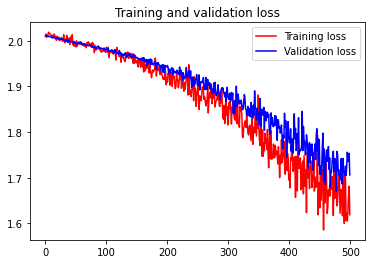

<Figure size 432x288 with 0 Axes>

In [17]:
#plot the loss and val_loss per epochs to a graph to know the proper epochs to avoid overfitting

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

###**ROC prediction**

plot the ROC prediction result as our parameter that functioned as accuracy in our model

In [18]:
#predict the roc for the model with 60 batch size from the test data
xx, yy = next(generator(test_normal_x, test_abnormal_x, 60))

prediction = model.predict(xx)

roc_auc_score(yy, prediction)

0.8744303385416666

load weights from the saved model to further results analysis

In [19]:
#load model weights from the saved model

model.load_weights('DigitalPolice-model.h5')

###**Confusion matrix**
Analyze the confusion matrix

In [20]:
#analyze the confusion matrix from the model, only count the prediction score that have > 0.5 values as the threshold

from sklearn.metrics import confusion_matrix

new_pred = prediction > 0.5

a = confusion_matrix(yy, new_pred)

tn, fp, fn, tp = a.ravel()
print(a)
print("tn = {}, fp = {}, fn = {}, tp = {}".format(tn, fp, fn, tp))


[[953   7]
 [734 226]]
tn = 953, fp = 7, fn = 734, tp = 226


###**Precision, Recall, F1, and False Alarm Rate**
analyze the precision, False Alarm Rate (from false positive rate), recall and f1 from the training result

In [21]:
precision = tp / (tp + fp)
FAR = fp / (fp + tn)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)

print("precision = {}, FAR (False Alarm rate = {}, recall = {}, f1 = {}".format(precision, FAR, recall, f1))

precision = 0.9699570815450643, FAR (False Alarm rate = 0.007291666666666667, recall = 0.23541666666666666, f1 = 0.37887678122380547


In [22]:
#analyze the predicted result from test abnormal or anomaly videos, indicates True for the anomaly with >0.5 values as it is nearer to the anomaly values (1)

for vid in test_abnormal_x:
  pr = model.predict(vid)

  pr = pr > 0.5

  out = True in pr

  print(out)


True
False
False
True
False
True
False
False
False
False
False
False
False
False
True
False
True
False
True
False
True
False
False
False
False
True
True
True
False
False
False
False
True
True
False
False
False
False
True
True
False
False
True
False
True
True
True
True
False
False
False
True
True
False
False
True
True
True
False
False
True
False
False
False
True
False
True
False
